In [1]:
"""
In this notebook, we experiment spam filtering model using Transfer learning with BERT based model.
Through this experimentation, we fine-tuned the BertForSequenceClassification model from HuggingFace
Transformers library.
Since Spam filtering is a classification task, we will take time to explore hypothesis and will use
different classifier from classical Machine Learning model such as RandomForestClassifier to 
deep Learning Model.
We use Pytorch framework to build our models.

@author: Koffi Moïse Agbenya
@since: 29/09/20
"""
# import preprocessing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Install Transformers Library

In [2]:
!pip install transformers

In [99]:
# import Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoModel, BertTokenizer
from transformers import AdamW

In [4]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random
from random import shuffle

In [6]:
!pip install torchtext

In [7]:
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Preliminaries (data preprocessing)

In [12]:
# Load data to pandas data frame
df = pd.read_csv('./spam_dataset/spam.csv', encoding='latin-1')
# Show the first 5 lines
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


At a glance, our dataset have 5 columns labeled ["v1", "v2", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"].
v1 contains the class of the line. It has 2 values (ham and spam), therefore 2  classes.
v2 contains the sms (email).
The 3 lasts columns are not interested for our work, thus, we will delete them. Besides, we will rename the v1 and v2 columns to respectively "class" and "email".

In [13]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = df.rename(columns={"v1":"class", "v2":"email"})
data.head(3)

,class,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [14]:
# print the shape of the dataset
data.shape

(5572, 2)

The dataset has 5572 emails. We will in the next section split the dataset into train, validation and test sets. Furthemore, we will preprocess the text of each email.

In [15]:
# Interested fact is to check the class distribution in order to prepare the way we will handle the task
data['class'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: class, dtype: float64

We can see that the dataset is unbalanced. We have around 87% of ham email and 13% of spam.

In [29]:
# change the categorical data to numeric
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['class_code'] = le.fit_transform(data['class'])
data.head(5)

,class,email,class_code
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Split train dataset to train, validation and test sets

In [30]:
# Firts things first, we split the dataset into train and temp sets and then split the temp set into validation set and test set
# We did it this way because to perform cross validation.
train_X, temp_X, train_Y, temp_Y = train_test_split(data['email'], data['class_code'],
                                                    random_state=2786,
                                                    test_size=0.3,
                                                    stratify= data['class_code'])

validation_X, test_X, validation_Y, test_Y = train_test_split(temp_X, temp_Y,
                                                             random_state=2786,
                                                             test_size=0.5,
                                                             stratify=temp_Y)

# Import BERT model and BERT tokenizer

In [100]:
# import BERT-base pretrained model
model = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization

We will get here the length of all the emails and plot a histogram. From the histogram, we will see the repartition in order to choose the maximum length and use it as our tokenizer max_length parameter

In [20]:
sequence_len = [len(sent.split()) for sent in train_X]

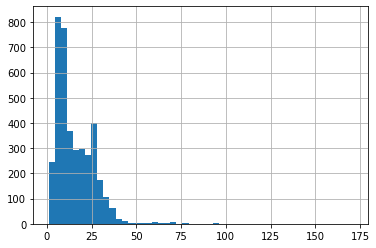

In [23]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.hist.html
pd.Series(sequence_len).hist(bins=50)

As we see on the histogram, a value of 25 is a good trade-off for our dataset. We will then pick the first 25 relevant words in the text.

In [24]:
MAX_SEQUENCE_LEN = 25

Now we will tokenize and encode sequences in the train, validation and test sets.
To understand why we proceeded this way, look at the following links:
> [Transformers documentation for preprocessing](https://huggingface.co/transformers/preprocessing.html)
> [Transformers documentation for Tokenizers utilities](https://huggingface.co/transformers/internal/tokenization_utils.html#pretrainedtokenizerbase) see : batch_encode_plus

In [26]:
# training set tokenization
train_tokens = tokenizer.batch_encode_plus(
    train_X.tolist(),
    max_length=MAX_SEQUENCE_LEN,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# test set tokenization
test_tokens = tokenizer.batch_encode_plus(
    test_X.tolist(),
    max_length=MAX_SEQUENCE_LEN,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# validation set tokenization
validation_tokens = tokenizer.batch_encode_plus(
    validation_X.tolist(),
    max_length=MAX_SEQUENCE_LEN,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert integer sequences to Tensor

In [31]:
# for train set
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_Y.tolist())

# for validation set
val_seq = torch.tensor(validation_tokens['input_ids'])
val_mask = torch.tensor(validation_tokens['attention_mask'])
val_y = torch.tensor(validation_Y.tolist())

# for test set
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_Y.tolist())

# Create Dataloaders

In [32]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define the batch size
BATCH_SIZE = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=BATCH_SIZE)

# Freeze BERT parameters

In [101]:
# freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

# Define Model Architecture

In [112]:
class SpamClassifier(nn.Module):
    
    def __init__(self, bert_model, hidden_layer_1, hidden_layer_2, number_of_classes, dropout_prob1=0.2, dropout_prob2=0.1):
        super(SpamClassifier, self).__init__()
        # bert model
        self.bert = bert_model
        # dropout layers
        self.dropout_1 = nn.Dropout(dropout_prob1)
        self.dropout_2 = nn.Dropout(dropout_prob2)
        # relu activation function
        self.relu = nn.ReLU()
        # fc layers
        self.fc1 = nn.Linear(768, hidden_layer_1) # 768 is the dimension of the bert model hidden layer output
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # Output layer
        self.output = nn.Linear(hidden_layer_2, number_of_classes)
        #softmax activation function
        #self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, sentence_id, mask):
        # Pass the inputs to the model
        _, hidden = self.bert(sentence_id, attention_mask=mask)
        # Pass through the first fc layer and relu activation
        out = self.relu(self.fc1(hidden))
        # Apply dropout
        out = self.dropout_1(out)
        # Pass through the second fc layer and relu activation
        out = self.relu(self.fc2(out))
        # Apply dropout
        out = self.dropout_2(out)
        # Output layer
        output = self.output(out)
        # Passs through sigmoid
        #output = self.softmax(out)
        return output

In [50]:
# Check if there is GPU
train_on_gpu = torch.cuda.is_available()
device = None
if(train_on_gpu):
    print('Training on GPU.')
    device = torch.device("cuda")
else:
    print('No GPU available, training on CPU.')
    device = torch.device("cpu")

Training on GPU.


In [122]:
# Init parameters
hidden_layer_1 = 512
hidden_layer_2 = 256
number_of_classes = 2
lr = 1e-3

In [113]:
# Define the Net architecture
net = SpamClassifier(model, hidden_layer_1, hidden_layer_2, number_of_classes)

print(net)

SpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [114]:
# Transfer on device
net.to(device)

SpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [123]:
# Define the optimizer
optimizer = AdamW(net.parameters(), lr=lr)

In [107]:
# Find class weight
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_Y), train_Y)

print(class_wts)

[0.57743559 3.72848948]


In [120]:
# Convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
# Transfer on device
weights.to(device)
#Loss function
criterion = nn.CrossEntropyLoss(weight=weights).to(device)

# Fine-tune BERT

In [124]:
def train():
  
    net.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        net.zero_grad()        

        # get model predictions for the current batch
        preds = net(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = criterion(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [125]:
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    net.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = net(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Training model

In [126]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Define number_of_epochs
epochs = 20

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.491
Validation Loss: 0.251

 Epoch 2 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.324
Validation Loss: 0.301

 Epoch 3 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.379
Validation Loss: 0.201

 Epoch 4 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.299
Validation Loss: 0.175

 Epoch 5 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.291
Validation Loss: 0.195

 Epoch 6 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.309
Validation Loss: 0.255

 Epoch 7 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.281
Validation Loss: 0.188

 Epoch 8 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.247
Validat

In [128]:
#load weights of best model
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [130]:
# get predictions for test data
with torch.no_grad():
  preds = net(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [131]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.85      0.95      0.89       112

    accuracy                           0.97       836
   macro avg       0.92      0.96      0.94       836
weighted avg       0.97      0.97      0.97       836



In [132]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,705,19
1,6,106


In [134]:
"""
rf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)
rf_classifier.fit(X_train, y_train)
preds = rf_classifier.predict(X_test)

fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()
"""


'\nrf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)\nrf_classifier.fit(X_train, y_train)\npreds = rf_classifier.predict(X_test)\n\nfig = plt.figure(figsize=(10,4))\nheatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))\nheatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha=\'right\', fontsize=14)\nheatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha=\'right\', fontsize=14)\nplt.ylabel(\'Ground Truth\')\nplt.xlabel(\'Prediction\')\nplt.show()\n'